## Prepare imports

In [10]:
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE
from models.encoder import BaseModel as EctEncoder
from datasets.shapenet import DataModule, DataModuleConfig
from layers.ect import EctLayer, EctConfig

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn
from layers.directions import generate_directions


DEVICE = "cuda:0"


config = OmegaConf.load("./configs/config_encoder_shapenet.yaml")

## Load Models and Data

In [11]:


from datasets import load_datamodule


layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(config.layer.ect_size, config.layer.dim, DEVICE),
)

dm = DataModule(DataModuleConfig())

# # Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/ectencoder_shapenet.ckpt",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.model.hidden_size,
    num_pts=config.model.num_pts,
    num_dims=config.model.num_dims,
    learning_rate=config.model.learning_rate,
).to(DEVICE)


In [12]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)
decoded = torch.zeros_like(ect)

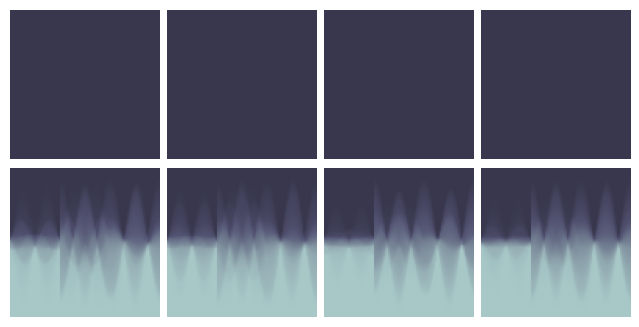

In [13]:
n_images = 4

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(8,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    
    ax[0].imshow(recon_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[0].axis("off")
    ax[1].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")
    

plt.savefig("./figures/img/modelnet/reconstructed_ect_vae.svg",transparent=True)

In [15]:
import pyvista as pv

with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect).cpu().detach().numpy()
    recon_batch_vae = ect_encoder_litmodel.model.forward(decoded).cpu().detach().numpy()


pl = pv.Plotter(shape=(2, 4), window_size=[800, 400],border=False,polygon_smoothing=True,off_screen=True)


row = 7
for col in range(4):
    points_vae = recon_batch_vae[row*8 + col].reshape(-1, 3)
    pl.subplot(0, col)
    actor = pl.add_points(
        points_vae,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points_vae[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )
    points = recon_batch[row*8 + col].reshape(-1, 3)
    pl.subplot(1,  col)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )
    


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/modelnet/reconstructed_vae_pointcloud.png",transparent_background=True,scale=2)
pl.show()
path = pl.generate_orbital_path(n_points=64, shift=2, factor=3.0)
pl.open_gif("./figures/img/modelnet/orbit_vae_cloud.gif")
pl.orbit_on_path(path, write_frames=True)
pl.close()


Widget(value='<iframe src="http://localhost:51669/index.html?ui=P_0x1f9caf06500_0&reconnect=auto" class="pyvis…

## Sample from VAE and reconstruct points 

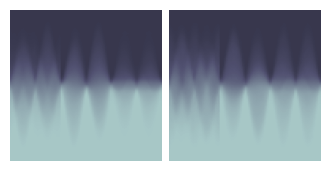

In [11]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1 ) / 2

n_images = 2

fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(4,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for sample, ax in zip(samples,axes.T):
    ax.imshow(sample.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax.axis("off")

plt.savefig("./figures/img/modelnet/generated_samples.svg",transparent=True)









In [12]:

import pyvista as pv

pl = pv.Plotter(shape=(1, 2), window_size=[400, 200],border=False,polygon_smoothing=True)

with torch.no_grad():
    batch_decoded = ect_encoder_litmodel.model.forward(samples)

batch_decoded = batch_decoded.cpu().detach().numpy()

points = batch_decoded[0].reshape(-1, 3)
pl.subplot(0,0)
actor = pl.add_points(
    points,
    style="points",
    emissive=False,
    show_scalar_bar=False,
    render_points_as_spheres=True,
    scalars=points[:, 2],
    point_size=5,
    ambient=0.2, 
    diffuse=0.8, 
    specular=0.8,
    specular_power=40, 
    smooth_shading=True
)


points = batch_decoded[1].reshape(-1, 3)
pl.subplot(0,1)
actor = pl.add_points(
    points,
    style="points",
    emissive=False,
    show_scalar_bar=False,
    render_points_as_spheres=True,
    scalars=points[:, 2],
    point_size=5,
    ambient=0.2, 
    diffuse=0.8, 
    specular=0.8,
    specular_power=40, 
    smooth_shading=True
)



pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/modelnet/generated_samples.png",transparent_background=True,scale=2)
pl.show()

Widget(value='<iframe src="http://localhost:64758/index.html?ui=P_0x1c9c2cf8100_2&reconnect=auto" class="pyvis…